# STIX flare from temporal decomposition paper
Here we analyze the 2022 Apr 20 flare observed by SoLO/STIX from the temporal decomposition paper.

We don't perform spectroscopy; we just demonstrate the decomposition technique.

## How to: set up this package
Please see the `readme.md` file in the root of this repository.

## How to: get data
Each STIX flare has its own unique ID. In this case, the data ID is `2204205961`.
You may download the data via the shell:
```bash
id=2204205961
stix_website='https://datacenter.stix.i4ds.net/download/fits/bsd'
curl "$stix_website/$id" > "$id.fits"
```

In [1]:
from yaff.extern import stix
from yaff.plotting import stairs_with_error

import astropy.units as u
import astropy.time as atime
from astropy.visualization import quantity_support
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tedec import decomp

## Define some helper functions for slicing up data

In [2]:
def nearest(a: np.ndarray, v):
    """Get the index of the element in `a` whose value is closest to `v`"""
    return np.argmin(np.abs(a - v))


def slice_spectrogram(spectrogram: dict, ta: atime.Time, tb: atime.Time) -> dict:
    """Take in a spectrogram dictionary and slice it up given two times."""
    # Change STIX UTC to Earth arrival time UTC
    time_bins = spectrogram["time_bin_edges"] + spectrogram["earth_spacecraft_dt"]

    # Find the time bin indices which are closest to our selected times
    ia, ib = nearest(time_bins, ta), nearest(time_bins, tb)

    ebins = spectrogram["energy_bin_edges"].copy()
    # The last energy bin is `nan`, so make it really large
    ebins[np.isnan(ebins)] = 1 << u.MeV

    # Slice out the data and time bins we want;
    # we need the "-1" because there are N time bins,
    # but N+1 time bin edges
    cts = spectrogram["counts"].T[:, ia : ib - 1]
    cts_err = spectrogram["counts_error"].T[:, ia : ib - 1]
    cut_livetime = spectrogram["livetime"][ia : ib - 1]
    cut_time_bins = time_bins[ia:ib]

    return {
        "time_bins": cut_time_bins,
        "cts": cts,
        "cts_err": cts_err,
        "livetime": cut_livetime,
        "energy_bins": ebins,
    }

## Load in the data and perform the temporal decomposition

### First, load the data and slice out the time range we want

In [3]:
file_name = "2204205961.fits"
full_spectrogram = stix.load_pixel_data_to_spectrogram(file_name)

# The analysis interval we used in the paper
TA = atime.Time("2022-04-20T01:12:20")
TB = atime.Time("2022-04-20T01:13:00")
sliced = slice_spectrogram(full_spectrogram, TA, TB)

### Then, perform the decomposition

In [4]:
# We want to apply any sort of lightcurve summations by indexing the
# energy midpoints, as they have the same shape as the counts.
energy_mids = sliced["energy_bins"][:-1] + np.diff(sliced["energy_bins"]) / 2

# Template energies for (thermal, nonthermal).
# We use a constant offset for the background component.
TH_ENG = 6 << u.keV
NTH_ENG = 19 << u.keV

# Find the indices of the count bins that are closest to our desired energies
th_idx = nearest(TH_ENG, energy_mids)
nth_idx = nearest(NTH_ENG, energy_mids)

# Package up all of our data into a DataPacket
pack = decomp.DataPacket(
    data=sliced["cts"],
    basis_timeseries=[
        # Take a few thermal and nonthermal and bkg energy bands and sum them
        # together to make the basis timeseries.
        # This helps with statistics and also makes it so that
        # no single energy band dominates the behavior of the emission
        sliced["cts"][th_idx - 1 : th_idx + 2].sum(axis=0),
        sliced["cts"][nth_idx - 1 : nth_idx + 2].sum(axis=0),
    ],
    constant_offset=True,
)

# Decompose the data using the `decomp` module
# See the docstring for more info
decomposed = decomp.bootstrap(
    dp=pack, errors=sliced["cts_err"], num_iter=3000, clip_negative=True
)

## Plot the decomposed data on top of the original data

[Text(0.5, 1.0, 'STIX decomposition'), None, None, (4, 100), (0.1, 40000.0)]

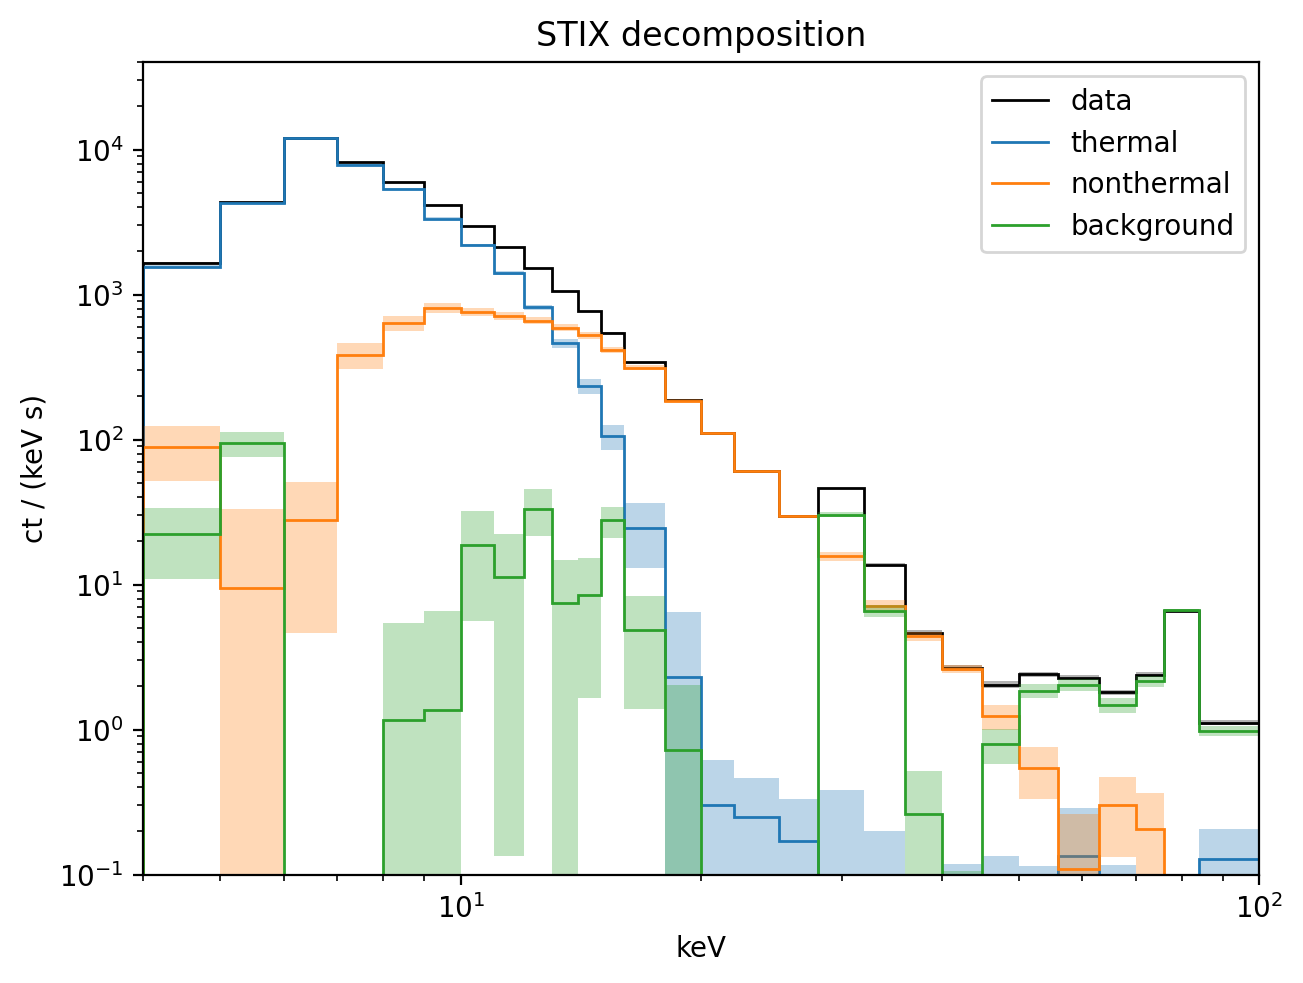

In [5]:
# As per the docstring, the decomposed data are the first N-1 entries, while the
# intercept is included in the final entry.
index_map = {"thermal": 0, "nonthermal": 1, "background": 2}

# Energy binning is nonuniform, so we divide it out
# for a nicer looking spectrum
de = np.diff(sliced["energy_bins"]) << u.keV

# Average the live time across all detector pairs
avg_livetime = sliced["livetime"].mean(axis=1)
dt = np.sum(np.diff(sliced["time_bins"]) * avg_livetime).to(u.s)

fig, ax = plt.subplots(layout="constrained")

all_counts = sliced["cts"].sum(axis=1)
all_errors = np.sqrt(np.sum(sliced["cts_err"] ** 2, axis=1))

with quantity_support():
    stairs_with_error(
        sliced["energy_bins"],
        all_counts / de / dt,
        all_errors / de / dt,
        ax=ax,
        label="data",
        line_kw={"color": "black"},
    )
    for label, index in index_map.items():
        # Get the samples associated with your pseudobasis
        samples = decomposed[:, index, :]
        avg_cts = np.mean(samples, axis=0) << u.ct
        avg_std = np.std(samples, axis=0) << u.ct

        stairs_with_error(
            sliced["energy_bins"],
            avg_cts / de / dt,
            avg_std / de / dt,
            ax=ax,
            label=label,
        )

ax.legend()
ax.set(
    title="STIX decomposition",
    xscale="log",
    yscale="log",
    xlim=(4, 100),
    ylim=(0.1, 4e4),
)

### We can see that the decomposed data captures the various components well.
### This is equivalent to Figure 2 from the paper.